# AUTOENCODERS!

## Key Concepts:

- An autoencoder:
    - A type of neural network that learns to compress and reconstruct data. It consists of two main components:

        - Encoder: Compresses input x into a latent-space representation z.
        - Decoder: Reconstructs input x′ from the latent-space representation z.

What is latent-space?
- lower-dimensional space represents the key features or abstract properties of the input data
- It is created by the encoder part of an autoencoder and is a compressed version of the original input
- Characteristics of a Latent Space
    - Compression:

        - The latent space is smaller than the input space, which forces the autoencoder to find compact representations.
    - Abstract Representations:
        - Instead of directly storing the input data, the latent space contains encoded information, ex:
            - Edges, shapes, or textures in images.
            - Word relationships in textual data.
    - Interpretability:

        - Each dimension in the latent space may correspond to a meaningful feature or property, depending on the training.

Training Basic Autoencoder...
313/313 [==============================] - 1s 2ms/step
Training Sparse Autoencoder...
313/313 [==============================] - 1s 2ms/step
Training Denoising Autoencoder...
313/313 [==============================] - 0s 910us/step
Training Convolutional Autoencoder...
313/313 [==============================] - 2s 8ms/step
Basic Autoencoder Loss: 0.0012
Sparse Autoencoder Loss: 0.0408
Denoising Autoencoder Loss: 0.0012
Convolutional Autoencoder Loss: 0.0084


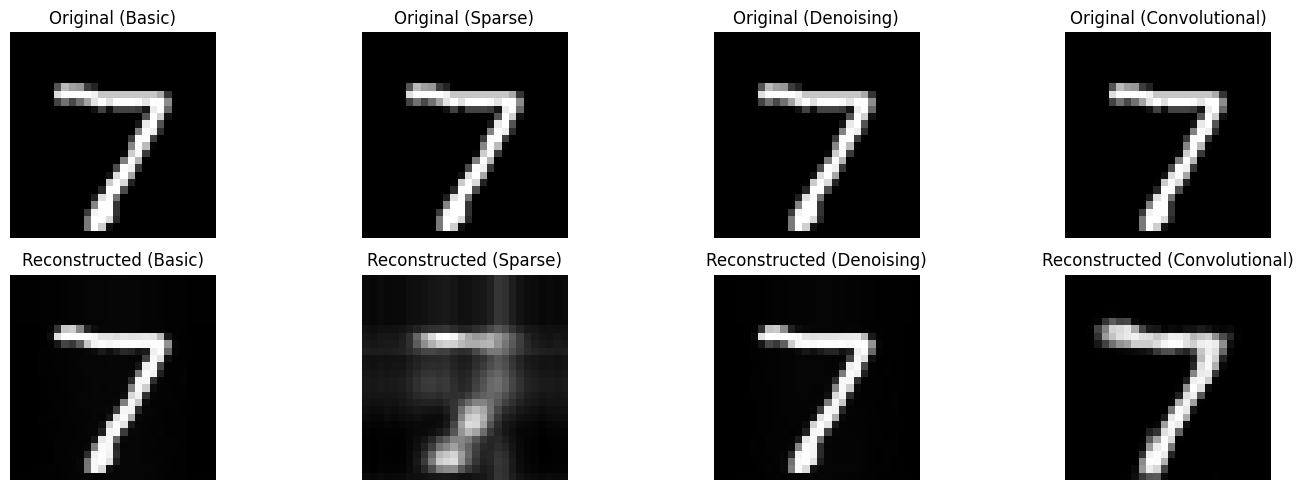

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


class AutoencoderSpecialUtilities:
    """Utility functions for various types of autoencoders."""

    @staticmethod
    def basic_autoencoder(input_dim, latent_dim):
        """Builds a basic autoencoder."""
        inputs = Input(shape=(input_dim,))
        encoded = Dense(latent_dim, activation="relu")(inputs)
        decoded = Dense(input_dim, activation="sigmoid")(encoded)
        autoencoder = Model(inputs, decoded, name="BasicAutoencoder")
        autoencoder.compile(optimizer="adam", loss="mse")
        return autoencoder

    @staticmethod
    def sparse_autoencoder(input_dim, latent_dim, sparsity=1e-3):
        """Builds a sparse autoencoder with L1 regularization."""
        from tensorflow.keras.regularizers import L1
        inputs = Input(shape=(input_dim,))
        encoded = Dense(latent_dim, activation="relu", activity_regularizer=L1(sparsity))(inputs)
        decoded = Dense(input_dim, activation="sigmoid")(encoded)
        autoencoder = Model(inputs, decoded, name="SparseAutoencoder")
        autoencoder.compile(optimizer="adam", loss="mse")
        return autoencoder

    @staticmethod
    def denoising_autoencoder(input_dim, latent_dim, noise_factor=0.1):
        """Builds a denoising autoencoder."""
        inputs = Input(shape=(input_dim,))
        noisy_inputs = tf.keras.layers.GaussianNoise(noise_factor)(inputs)
        encoded = Dense(latent_dim, activation="relu")(noisy_inputs)
        decoded = Dense(input_dim, activation="sigmoid")(encoded)
        autoencoder = Model(inputs, decoded, name="DenoisingAutoencoder")
        autoencoder.compile(optimizer="adam", loss="mse")
        return autoencoder

    @staticmethod
    def convolutional_autoencoder(input_shape, latent_dim):
        """Builds a convolutional autoencoder."""
        # Encoder
        inputs = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        encoded = Flatten()(x)
        encoded = Dense(latent_dim, activation="relu")(encoded)

        # Decoder
        x = Dense(np.prod(input_shape), activation="relu")(encoded)
        x = Reshape(input_shape)(x)
        x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
        decoded = Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

        autoencoder = Model(inputs, decoded, name="ConvolutionalAutoencoder")
        autoencoder.compile(optimizer="adam", loss="mse")
        return autoencoder


class AutoencoderSpecialHelper:
    """Runs a pipeline for all types of autoencoders and compares results."""

    def __init__(self, X_train, X_test, input_dim, image_shape=None, latent_dim=32, noise_factor=0.1, sparsity=1e-3):
        self.X_train = X_train
        self.X_test = X_test
        self.input_dim = input_dim
        self.image_shape = image_shape
        self.latent_dim = latent_dim
        self.noise_factor = noise_factor
        self.sparsity = sparsity
        self.autoencoders = {}

    def setup_autoencoders(self):
        """Initialize autoencoders with current settings."""
        self.autoencoders = {
            "Basic": AutoencoderSpecialUtilities.basic_autoencoder(self.input_dim, self.latent_dim),
            "Sparse": AutoencoderSpecialUtilities.sparse_autoencoder(self.input_dim, self.latent_dim, self.sparsity),
            "Denoising": AutoencoderSpecialUtilities.denoising_autoencoder(self.input_dim, self.latent_dim, self.noise_factor),
        }
        if self.image_shape:
            self.autoencoders["Convolutional"] = AutoencoderSpecialUtilities.convolutional_autoencoder(
                self.image_shape, self.latent_dim
            )

    def train_and_evaluate(self, epochs=10, batch_size=128):
        """Train all autoencoders and visualize the results."""
        results = {}
        reconstructions = {}

        # Train each autoencoder
        for name, model in self.autoencoders.items():
            print(f"Training {name} Autoencoder...")
            if name == "Convolutional":
                # Reshape for Convolutional Autoencoder
                X_train_reshaped = self.X_train.reshape((-1, *self.image_shape))
                X_test_reshaped = self.X_test.reshape((-1, *self.image_shape))
                model.fit(
                    X_train_reshaped,
                    X_train_reshaped,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1,
                )
                reconstructions[name] = model.predict(X_test_reshaped)
                # Flatten reconstruction for MSE calculation
                flattened_reconstructed = reconstructions[name].reshape((-1, np.prod(self.image_shape)))
                flattened_original = X_test_reshaped.reshape((-1, np.prod(self.image_shape)))
                results[name] = mean_squared_error(flattened_original, flattened_reconstructed)
            else:
                model.fit(self.X_train, self.X_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
                reconstructions[name] = model.predict(self.X_test)
                # Flatten data for MSE calculation
                results[name] = mean_squared_error(
                    self.X_test.reshape((-1, np.prod(self.X_test.shape[1:]))),
                    reconstructions[name].reshape((-1, np.prod(self.X_test.shape[1:]))),
                )

        # Print losses
        for name, loss in results.items():
            print(f"{name} Autoencoder Loss: {loss:.4f}")

        # Visualize reconstructions
        self.visualize_reconstructions(reconstructions)


    def visualize_reconstructions(self, reconstructions):
        """Visualize the original and reconstructed images for all autoencoders."""
        num_encoders = len(reconstructions)
        plt.figure(figsize=(15, 5))

        for idx, (name, reconstructed) in enumerate(reconstructions.items()):
            plt.subplot(2, num_encoders, idx + 1)
            plt.title(f"Original ({name})")
            plt.imshow(self.X_test[0].reshape(28, 28), cmap="gray")
            plt.axis("off")

            plt.subplot(2, num_encoders, idx + 1 + num_encoders)
            plt.title(f"Reconstructed ({name})")
            if name == "Convolutional":
                plt.imshow(reconstructed[0].squeeze(), cmap="gray")
            else:
                plt.imshow(reconstructed[0].reshape(28, 28), cmap="gray")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


# Example Usage
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

helper = AutoencoderSpecialHelper(
    X_train, X_test, input_dim=X_train.shape[1], image_shape=(28, 28, 1)
)

helper.setup_autoencoders()
helper.train_and_evaluate(epochs=10, batch_size=128)

